In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import catboost as ctb
from bayes_opt import BayesianOptimization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
   

В данном соревновании имеются два вида данных: табличные и картинки.
   Проанализируем табличные данные и построим на них первый бейзлайн.

In [2]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
train['target'].value_counts() #дисбаланс классов

0    32542
1      584
Name: target, dtype: int64

In [4]:
train['target'].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [5]:
#проверим отсутствие пустых значений
train.isnull().sum() 

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

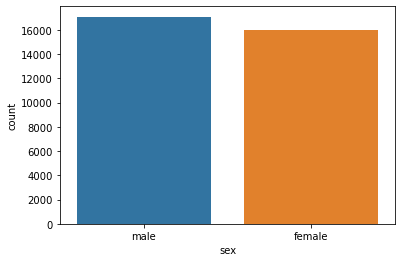

In [6]:
sns.countplot(data=train, x='sex') 
# существенной разницы по количеству мужчин и женщин не видно

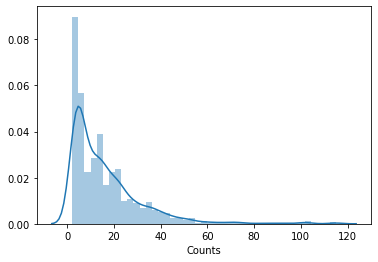

In [7]:
patient = train['patient_id'].value_counts()
sns.distplot(patient, axlabel='Counts', label='Frequency')

#для многих пациентов мы имеем несколько наблюдений

Text(0.5, 1.0, 'Malignant cases in train')

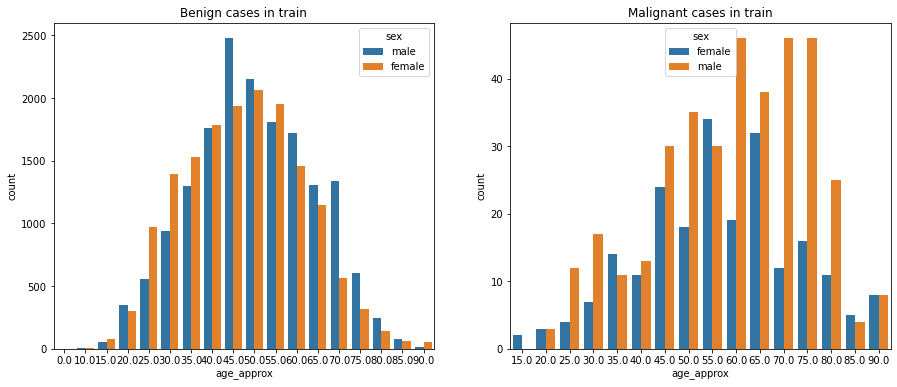

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.countplot(data=train.loc[train['target']==0], x='age_approx', hue="sex", ax=ax[0]) 
ax[0].set_title("Benign cases in train");
sns.countplot(data=train.loc[train['target']==1], x='age_approx', hue="sex", ax=ax[1]) 
ax[1].set_title("Malignant cases in train")

#в части данных отсутствует и возраст и пол
#вероятность злокачественного образования повышается у мужчин 70-75 лет

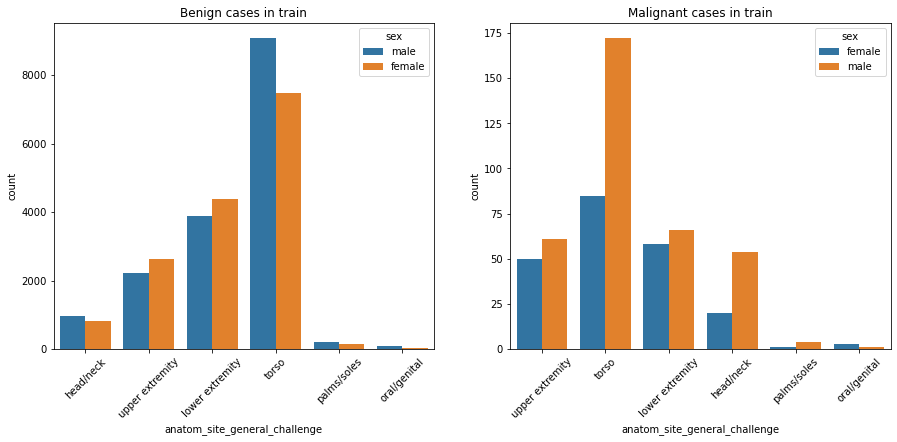

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.countplot(data=train.loc[train['target']==0], x='anatom_site_general_challenge', hue="sex", ax=ax[0]) 
ax[0].set_title("Benign cases in train")
ax[0].tick_params(axis='x', rotation=45)
sns.countplot(data=train.loc[train['target']==1], x='anatom_site_general_challenge', hue="sex", ax=ax[1]) 
ax[1].set_title("Malignant cases in train")
ax[1].tick_params(axis='x', rotation=45)

#у мужчин злокачественные новообразования встречаются чаще

In [10]:
train['sex'] = train['sex'].fillna('na')
train['age_approx'] = train['age_approx'].fillna(0)
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('na')

In [11]:
#выделим возраст первого и последнего наблюдения для каждого пациента
train['age_id_min'] = train['patient_id'].map(train.groupby(['patient_id']).age_approx.min())
train['age_id_max'] = train['patient_id'].map(train.groupby(['patient_id']).age_approx.max())


In [12]:
train.loc[train['age_id_min'] != train['age_id_max']]['target'].value_counts(normalize=True)

0    0.979952
1    0.020048
Name: target, dtype: float64

In [13]:
train.loc[train['age_id_min'] == train['age_id_max']]['target'].value_counts(normalize=True)
#делаем предположение, что вероятность злокачественного образования больше, если пациент обследовался повторно

0    0.984803
1    0.015197
Name: target, dtype: float64

In [14]:
#добавим среднее значение цвета изображения https://www.kaggle.com/awsaf49/mean-color-isic2020/
train_mean_color = pd.read_csv('/kaggle/input/mean-color-isic2020/train_color.csv')
train['mean_color'] = train_mean_color.values

In [15]:
#save
train.to_csv('train_all.csv')


In [16]:
#так как данные очень не сбалансированные, мы возьмем только часть отрицательных случаев

df_0 = train[train['target']==0].sample(3000, random_state=1)
df_1 = train[train['target']==1]
train = pd.concat([df_0,df_1])
train = train.reset_index()
train['target'].value_counts(normalize=True)

0    0.837054
1    0.162946
Name: target, dtype: float64

In [17]:
#создадим отложенную выборку
feat=['anatom_site_general_challenge', 'sex', 'age_approx', 'age_id_min', 'age_id_max', 'mean_color']
train, test, y_train, y_test = train_test_split(train[feat], train['target'], test_size=0.2, random_state=42)

In [18]:
#соотношение классов осталось преждним
y_train.value_counts(normalize=True)

0    0.831531
1    0.168469
Name: target, dtype: float64

In [19]:
#преобразуем текстовые ячейки в категориальные переменные и добавим численные переменные

encoder = OrdinalEncoder()
train_data = encoder.fit_transform(train[['anatom_site_general_challenge', 'sex']])
train_data = np.concatenate((train_data, np.array(train[['age_approx', 'age_id_min', 'age_id_max', 'mean_color']])), axis=1)

test_data = encoder.transform(test[['anatom_site_general_challenge', 'sex']])
test_data = np.concatenate((test_data, np.array(test[['age_approx', 'age_id_min', 'age_id_max', 'mean_color']])), axis=1)

train_df = pd.DataFrame(train_data, columns=[['anatom_site_general_challenge', 'sex', 'age_approx', 'age_id_min', 'age_id_max', 'mean_color']])

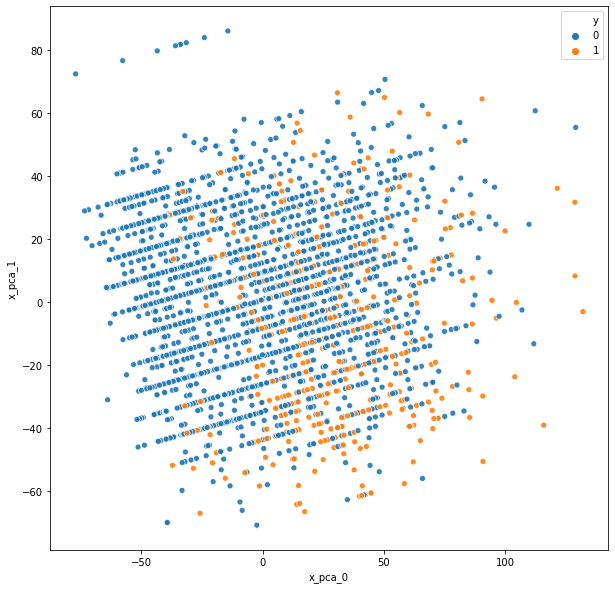

In [20]:
#Попробуем визуализировать классы в двумерном пространстве

from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(train_data)

pca_df = pd.DataFrame({'x_pca_0':X_pca[:,0],
             'x_pca_1':X_pca[:,1],
             'y':y_train})

plt.figure(figsize = (10,10))
sns.scatterplot(
    x="x_pca_0", y="x_pca_1",
    hue="y",
    data=pca_df,
    legend="full",
    alpha=0.9
)

#линейно выделить классы нельзя, но при этом замете сдвиг первого класса в правую сторону

In [21]:
train_data.shape

(2867, 6)

In [22]:
#отмасштабируем данные и проведем кросс-валидацию логистической регрессии
kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=42))])
cross_val_score(pipe_lr, train_data, y_train, cv=kfold, scoring="roc_auc")


array([0.76917848, 0.75159967, 0.78736486])

In [23]:
#подберем параметры для логистической регрессии
param_grid = { 
    'lr__C': [0.5, 1, 5, 10],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

CV_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, cv=kfold, scoring="roc_auc")
CV_lr.fit(train_data, y_train)
print(CV_lr.best_params_)
print(CV_lr.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/pyt

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/opt/conda

{'lr__C': 5, 'lr__penalty': 'l2'}
0.7696388716118312


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/pyt

In [24]:
#посмотрим значение метрики
metrics =  {}
metrics['LR'] = roc_auc_score(y_test, CV_lr.predict_proba(test_data)[:,1])
print(metrics['LR'])

0.7874662466246625


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, CV_lr.predict(test_data), digits=4))

              precision    recall  f1-score   support

           0     0.8721    0.9854    0.9253       616
           1     0.5714    0.1188    0.1967       101

    accuracy                         0.8633       717
   macro avg     0.7218    0.5521    0.5610       717
weighted avg     0.8298    0.8633    0.8227       717



In [26]:
#попробуем улучшить результат, используя деревья решений
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(train_df, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

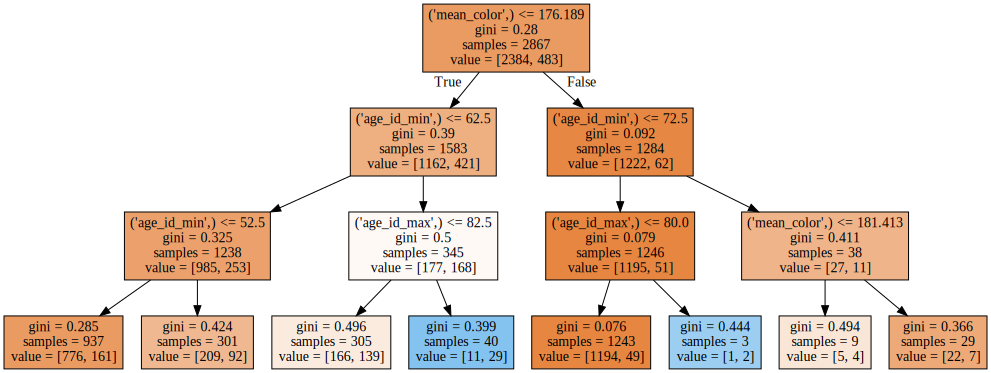

In [27]:
#визуализируем дерево
import graphviz 
from graphviz import Source
from sklearn import tree
dot_data = tree.export_graphviz(tree_clf, out_file='tree.dot', feature_names=train_df.columns, filled=True)
Source.from_file('tree.dot')

In [28]:
#построим ансамбль деревьев
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
cross_val_score(forest_clf, train_data, y_train, cv=kfold, scoring="roc_auc")

array([0.71492636, 0.68650338, 0.69399768])

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [30]:
CV_rfc = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv=3, scoring="roc_auc")
CV_rfc.fit(train_data, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.7800849135814203


In [31]:
metrics['FR'] = roc_auc_score(y_test, CV_rfc.predict_proba(test_data)[:,1])
print(metrics['FR'])

0.7856178474990355


In [32]:
print(classification_report(y_test, CV_rfc.predict(test_data), digits=4))

              precision    recall  f1-score   support

           0     0.8714    0.9903    0.9271       616
           1     0.6471    0.1089    0.1864       101

    accuracy                         0.8661       717
   macro avg     0.7592    0.5496    0.5567       717
weighted avg     0.8398    0.8661    0.8227       717



In [33]:
#используем модель градиентного спуска
feat = ['age_approx', 'anatom_site_general_challenge', 'sex', 'age_id_min', 'age_id_max', 'mean_color']
params = {'random_state':42, 'cat_features': [1,2]}
clf_ctb = ctb.CatBoostClassifier(**params)
cross_val_score(clf_ctb, train[feat], y_train, cv=kfold, scoring="roc_auc")

Learning rate set to 0.013584
0:	learn: 0.6829391	total: 66.3ms	remaining: 1m 6s
1:	learn: 0.6718386	total: 70.5ms	remaining: 35.2s
2:	learn: 0.6614110	total: 74.5ms	remaining: 24.7s
3:	learn: 0.6523502	total: 79ms	remaining: 19.7s
4:	learn: 0.6424330	total: 83.6ms	remaining: 16.6s
5:	learn: 0.6335538	total: 89ms	remaining: 14.8s
6:	learn: 0.6247058	total: 94.9ms	remaining: 13.5s
7:	learn: 0.6158816	total: 98.7ms	remaining: 12.2s
8:	learn: 0.6082934	total: 103ms	remaining: 11.4s
9:	learn: 0.6018342	total: 105ms	remaining: 10.4s
10:	learn: 0.5952680	total: 109ms	remaining: 9.83s
11:	learn: 0.5905363	total: 111ms	remaining: 9.15s
12:	learn: 0.5831877	total: 115ms	remaining: 8.75s
13:	learn: 0.5787715	total: 117ms	remaining: 8.21s
14:	learn: 0.5738825	total: 120ms	remaining: 7.86s
15:	learn: 0.5672003	total: 123ms	remaining: 7.57s
16:	learn: 0.5632097	total: 124ms	remaining: 7.2s
17:	learn: 0.5593334	total: 126ms	remaining: 6.88s
18:	learn: 0.5536561	total: 129ms	remaining: 6.65s
19:	lear

165:	learn: 0.3720746	total: 563ms	remaining: 2.83s
166:	learn: 0.3719210	total: 567ms	remaining: 2.83s
167:	learn: 0.3716283	total: 571ms	remaining: 2.83s
168:	learn: 0.3712132	total: 574ms	remaining: 2.82s
169:	learn: 0.3709113	total: 578ms	remaining: 2.82s
170:	learn: 0.3708907	total: 579ms	remaining: 2.81s
171:	learn: 0.3708521	total: 582ms	remaining: 2.8s
172:	learn: 0.3706605	total: 586ms	remaining: 2.8s
173:	learn: 0.3703900	total: 589ms	remaining: 2.8s
174:	learn: 0.3702544	total: 592ms	remaining: 2.79s
175:	learn: 0.3702367	total: 594ms	remaining: 2.78s
176:	learn: 0.3699802	total: 597ms	remaining: 2.77s
177:	learn: 0.3698210	total: 600ms	remaining: 2.77s
178:	learn: 0.3694608	total: 603ms	remaining: 2.77s
179:	learn: 0.3692938	total: 607ms	remaining: 2.76s
180:	learn: 0.3690795	total: 610ms	remaining: 2.76s
181:	learn: 0.3687883	total: 614ms	remaining: 2.76s
182:	learn: 0.3685548	total: 617ms	remaining: 2.75s
183:	learn: 0.3684248	total: 620ms	remaining: 2.75s
184:	learn: 0.3

335:	learn: 0.3487709	total: 1.14s	remaining: 2.25s
336:	learn: 0.3486790	total: 1.14s	remaining: 2.25s
337:	learn: 0.3486056	total: 1.14s	remaining: 2.24s
338:	learn: 0.3484202	total: 1.15s	remaining: 2.24s
339:	learn: 0.3483501	total: 1.15s	remaining: 2.24s
340:	learn: 0.3483212	total: 1.15s	remaining: 2.23s
341:	learn: 0.3482161	total: 1.16s	remaining: 2.23s
342:	learn: 0.3481775	total: 1.16s	remaining: 2.22s
343:	learn: 0.3479342	total: 1.16s	remaining: 2.22s
344:	learn: 0.3477693	total: 1.17s	remaining: 2.21s
345:	learn: 0.3476702	total: 1.17s	remaining: 2.21s
346:	learn: 0.3476317	total: 1.17s	remaining: 2.2s
347:	learn: 0.3475348	total: 1.17s	remaining: 2.2s
348:	learn: 0.3475064	total: 1.18s	remaining: 2.2s
349:	learn: 0.3474271	total: 1.18s	remaining: 2.19s
350:	learn: 0.3473274	total: 1.18s	remaining: 2.19s
351:	learn: 0.3473006	total: 1.19s	remaining: 2.19s
352:	learn: 0.3473003	total: 1.19s	remaining: 2.18s
353:	learn: 0.3471977	total: 1.19s	remaining: 2.17s
354:	learn: 0.3

499:	learn: 0.3328856	total: 1.63s	remaining: 1.63s
500:	learn: 0.3328131	total: 1.64s	remaining: 1.63s
501:	learn: 0.3326596	total: 1.64s	remaining: 1.63s
502:	learn: 0.3325140	total: 1.64s	remaining: 1.62s
503:	learn: 0.3323462	total: 1.65s	remaining: 1.62s
504:	learn: 0.3320828	total: 1.65s	remaining: 1.62s
505:	learn: 0.3320409	total: 1.66s	remaining: 1.62s
506:	learn: 0.3318767	total: 1.66s	remaining: 1.61s
507:	learn: 0.3318706	total: 1.66s	remaining: 1.61s
508:	learn: 0.3318380	total: 1.67s	remaining: 1.61s
509:	learn: 0.3316466	total: 1.67s	remaining: 1.61s
510:	learn: 0.3316202	total: 1.68s	remaining: 1.6s
511:	learn: 0.3315861	total: 1.68s	remaining: 1.6s
512:	learn: 0.3314409	total: 1.68s	remaining: 1.6s
513:	learn: 0.3314099	total: 1.69s	remaining: 1.59s
514:	learn: 0.3312784	total: 1.69s	remaining: 1.59s
515:	learn: 0.3311956	total: 1.69s	remaining: 1.59s
516:	learn: 0.3311299	total: 1.7s	remaining: 1.58s
517:	learn: 0.3310851	total: 1.7s	remaining: 1.58s
518:	learn: 0.330

666:	learn: 0.3158621	total: 2.21s	remaining: 1.1s
667:	learn: 0.3157080	total: 2.21s	remaining: 1.1s
668:	learn: 0.3156043	total: 2.21s	remaining: 1.09s
669:	learn: 0.3155564	total: 2.22s	remaining: 1.09s
670:	learn: 0.3155499	total: 2.22s	remaining: 1.09s
671:	learn: 0.3154021	total: 2.22s	remaining: 1.08s
672:	learn: 0.3153938	total: 2.23s	remaining: 1.08s
673:	learn: 0.3152150	total: 2.23s	remaining: 1.08s
674:	learn: 0.3151559	total: 2.23s	remaining: 1.07s
675:	learn: 0.3150275	total: 2.24s	remaining: 1.07s
676:	learn: 0.3148343	total: 2.24s	remaining: 1.07s
677:	learn: 0.3147553	total: 2.24s	remaining: 1.06s
678:	learn: 0.3147304	total: 2.25s	remaining: 1.06s
679:	learn: 0.3146474	total: 2.25s	remaining: 1.06s
680:	learn: 0.3145553	total: 2.25s	remaining: 1.05s
681:	learn: 0.3145244	total: 2.26s	remaining: 1.05s
682:	learn: 0.3144688	total: 2.26s	remaining: 1.05s
683:	learn: 0.3143453	total: 2.26s	remaining: 1.04s
684:	learn: 0.3141921	total: 2.27s	remaining: 1.04s
685:	learn: 0.

844:	learn: 0.2999126	total: 2.79s	remaining: 512ms
845:	learn: 0.2998935	total: 2.79s	remaining: 508ms
846:	learn: 0.2998687	total: 2.79s	remaining: 505ms
847:	learn: 0.2998499	total: 2.8s	remaining: 502ms
848:	learn: 0.2996575	total: 2.8s	remaining: 498ms
849:	learn: 0.2995157	total: 2.81s	remaining: 495ms
850:	learn: 0.2993928	total: 2.81s	remaining: 492ms
851:	learn: 0.2993127	total: 2.81s	remaining: 488ms
852:	learn: 0.2992600	total: 2.81s	remaining: 485ms
853:	learn: 0.2992416	total: 2.82s	remaining: 482ms
854:	learn: 0.2991908	total: 2.82s	remaining: 478ms
855:	learn: 0.2990961	total: 2.82s	remaining: 475ms
856:	learn: 0.2990853	total: 2.83s	remaining: 472ms
857:	learn: 0.2990356	total: 2.83s	remaining: 469ms
858:	learn: 0.2988782	total: 2.83s	remaining: 465ms
859:	learn: 0.2988341	total: 2.84s	remaining: 462ms
860:	learn: 0.2987950	total: 2.84s	remaining: 459ms
861:	learn: 0.2986755	total: 2.84s	remaining: 455ms
862:	learn: 0.2985173	total: 2.85s	remaining: 452ms
863:	learn: 0.

31:	learn: 0.4907240	total: 111ms	remaining: 3.36s
32:	learn: 0.4868304	total: 117ms	remaining: 3.44s
33:	learn: 0.4847019	total: 119ms	remaining: 3.38s
34:	learn: 0.4809672	total: 124ms	remaining: 3.43s
35:	learn: 0.4776632	total: 127ms	remaining: 3.39s
36:	learn: 0.4735043	total: 132ms	remaining: 3.43s
37:	learn: 0.4709164	total: 136ms	remaining: 3.44s
38:	learn: 0.4678934	total: 140ms	remaining: 3.44s
39:	learn: 0.4647549	total: 145ms	remaining: 3.48s
40:	learn: 0.4614068	total: 149ms	remaining: 3.5s
41:	learn: 0.4594956	total: 152ms	remaining: 3.46s
42:	learn: 0.4561894	total: 156ms	remaining: 3.47s
43:	learn: 0.4536795	total: 159ms	remaining: 3.46s
44:	learn: 0.4518087	total: 163ms	remaining: 3.46s
45:	learn: 0.4486699	total: 167ms	remaining: 3.47s
46:	learn: 0.4473572	total: 169ms	remaining: 3.42s
47:	learn: 0.4446431	total: 172ms	remaining: 3.42s
48:	learn: 0.4424516	total: 175ms	remaining: 3.4s
49:	learn: 0.4408874	total: 179ms	remaining: 3.41s
50:	learn: 0.4395372	total: 181ms

215:	learn: 0.3575663	total: 691ms	remaining: 2.51s
216:	learn: 0.3573871	total: 695ms	remaining: 2.51s
217:	learn: 0.3572683	total: 699ms	remaining: 2.51s
218:	learn: 0.3572256	total: 701ms	remaining: 2.5s
219:	learn: 0.3571016	total: 704ms	remaining: 2.5s
220:	learn: 0.3570546	total: 707ms	remaining: 2.49s
221:	learn: 0.3568430	total: 710ms	remaining: 2.49s
222:	learn: 0.3567033	total: 713ms	remaining: 2.48s
223:	learn: 0.3566804	total: 715ms	remaining: 2.48s
224:	learn: 0.3566104	total: 718ms	remaining: 2.47s
225:	learn: 0.3565241	total: 721ms	remaining: 2.47s
226:	learn: 0.3564051	total: 724ms	remaining: 2.46s
227:	learn: 0.3561313	total: 727ms	remaining: 2.46s
228:	learn: 0.3557436	total: 731ms	remaining: 2.46s
229:	learn: 0.3557170	total: 733ms	remaining: 2.45s
230:	learn: 0.3556919	total: 735ms	remaining: 2.45s
231:	learn: 0.3556095	total: 737ms	remaining: 2.44s
232:	learn: 0.3555556	total: 739ms	remaining: 2.43s
233:	learn: 0.3554286	total: 743ms	remaining: 2.43s
234:	learn: 0.

402:	learn: 0.3379143	total: 1.29s	remaining: 1.91s
403:	learn: 0.3379105	total: 1.29s	remaining: 1.91s
404:	learn: 0.3377954	total: 1.3s	remaining: 1.9s
405:	learn: 0.3377040	total: 1.3s	remaining: 1.9s
406:	learn: 0.3376203	total: 1.3s	remaining: 1.9s
407:	learn: 0.3376202	total: 1.3s	remaining: 1.89s
408:	learn: 0.3376008	total: 1.31s	remaining: 1.89s
409:	learn: 0.3375922	total: 1.31s	remaining: 1.88s
410:	learn: 0.3374666	total: 1.31s	remaining: 1.88s
411:	learn: 0.3374596	total: 1.31s	remaining: 1.88s
412:	learn: 0.3374544	total: 1.32s	remaining: 1.87s
413:	learn: 0.3374055	total: 1.32s	remaining: 1.87s
414:	learn: 0.3373364	total: 1.32s	remaining: 1.86s
415:	learn: 0.3371896	total: 1.32s	remaining: 1.86s
416:	learn: 0.3371554	total: 1.33s	remaining: 1.86s
417:	learn: 0.3370854	total: 1.33s	remaining: 1.85s
418:	learn: 0.3369355	total: 1.33s	remaining: 1.85s
419:	learn: 0.3368357	total: 1.34s	remaining: 1.85s
420:	learn: 0.3368309	total: 1.34s	remaining: 1.84s
421:	learn: 0.33674

600:	learn: 0.3225361	total: 1.87s	remaining: 1.24s
601:	learn: 0.3225126	total: 1.88s	remaining: 1.24s
602:	learn: 0.3225107	total: 1.88s	remaining: 1.24s
603:	learn: 0.3224946	total: 1.88s	remaining: 1.23s
604:	learn: 0.3224679	total: 1.88s	remaining: 1.23s
605:	learn: 0.3223844	total: 1.89s	remaining: 1.23s
606:	learn: 0.3222039	total: 1.89s	remaining: 1.22s
607:	learn: 0.3221705	total: 1.89s	remaining: 1.22s
608:	learn: 0.3221173	total: 1.89s	remaining: 1.22s
609:	learn: 0.3221157	total: 1.9s	remaining: 1.21s
610:	learn: 0.3221025	total: 1.9s	remaining: 1.21s
611:	learn: 0.3220467	total: 1.9s	remaining: 1.21s
612:	learn: 0.3219847	total: 1.91s	remaining: 1.2s
613:	learn: 0.3219009	total: 1.91s	remaining: 1.2s
614:	learn: 0.3218508	total: 1.91s	remaining: 1.2s
615:	learn: 0.3216551	total: 1.92s	remaining: 1.19s
616:	learn: 0.3214689	total: 1.92s	remaining: 1.19s
617:	learn: 0.3213070	total: 1.92s	remaining: 1.19s
618:	learn: 0.3212524	total: 1.93s	remaining: 1.19s
619:	learn: 0.3212

780:	learn: 0.3057832	total: 2.46s	remaining: 689ms
781:	learn: 0.3057598	total: 2.46s	remaining: 686ms
782:	learn: 0.3056837	total: 2.46s	remaining: 683ms
783:	learn: 0.3056053	total: 2.47s	remaining: 680ms
784:	learn: 0.3055916	total: 2.47s	remaining: 677ms
785:	learn: 0.3054452	total: 2.47s	remaining: 673ms
786:	learn: 0.3052937	total: 2.48s	remaining: 670ms
787:	learn: 0.3052017	total: 2.48s	remaining: 667ms
788:	learn: 0.3050903	total: 2.48s	remaining: 664ms
789:	learn: 0.3048990	total: 2.49s	remaining: 661ms
790:	learn: 0.3048910	total: 2.49s	remaining: 658ms
791:	learn: 0.3047427	total: 2.49s	remaining: 654ms
792:	learn: 0.3046877	total: 2.49s	remaining: 651ms
793:	learn: 0.3045924	total: 2.5s	remaining: 648ms
794:	learn: 0.3044368	total: 2.5s	remaining: 645ms
795:	learn: 0.3043923	total: 2.5s	remaining: 642ms
796:	learn: 0.3043082	total: 2.51s	remaining: 639ms
797:	learn: 0.3041939	total: 2.51s	remaining: 636ms
798:	learn: 0.3039884	total: 2.52s	remaining: 633ms
799:	learn: 0.3

953:	learn: 0.2895629	total: 3.04s	remaining: 147ms
954:	learn: 0.2893389	total: 3.05s	remaining: 144ms
955:	learn: 0.2893043	total: 3.05s	remaining: 140ms
956:	learn: 0.2892849	total: 3.05s	remaining: 137ms
957:	learn: 0.2892585	total: 3.06s	remaining: 134ms
958:	learn: 0.2891552	total: 3.06s	remaining: 131ms
959:	learn: 0.2890602	total: 3.06s	remaining: 128ms
960:	learn: 0.2890193	total: 3.07s	remaining: 124ms
961:	learn: 0.2888879	total: 3.07s	remaining: 121ms
962:	learn: 0.2888481	total: 3.07s	remaining: 118ms
963:	learn: 0.2887803	total: 3.08s	remaining: 115ms
964:	learn: 0.2887415	total: 3.08s	remaining: 112ms
965:	learn: 0.2887123	total: 3.08s	remaining: 108ms
966:	learn: 0.2886386	total: 3.08s	remaining: 105ms
967:	learn: 0.2886178	total: 3.09s	remaining: 102ms
968:	learn: 0.2885630	total: 3.09s	remaining: 98.9ms
969:	learn: 0.2885199	total: 3.09s	remaining: 95.7ms
970:	learn: 0.2884853	total: 3.1s	remaining: 92.5ms
971:	learn: 0.2884470	total: 3.1s	remaining: 89.3ms
972:	learn

146:	learn: 0.3781722	total: 385ms	remaining: 2.23s
147:	learn: 0.3778669	total: 388ms	remaining: 2.23s
148:	learn: 0.3774565	total: 391ms	remaining: 2.23s
149:	learn: 0.3773733	total: 393ms	remaining: 2.22s
150:	learn: 0.3770925	total: 395ms	remaining: 2.22s
151:	learn: 0.3767925	total: 398ms	remaining: 2.22s
152:	learn: 0.3766209	total: 400ms	remaining: 2.21s
153:	learn: 0.3762266	total: 403ms	remaining: 2.21s
154:	learn: 0.3761899	total: 405ms	remaining: 2.21s
155:	learn: 0.3758769	total: 407ms	remaining: 2.2s
156:	learn: 0.3757697	total: 410ms	remaining: 2.2s
157:	learn: 0.3752538	total: 413ms	remaining: 2.2s
158:	learn: 0.3750253	total: 416ms	remaining: 2.2s
159:	learn: 0.3745224	total: 419ms	remaining: 2.2s
160:	learn: 0.3743894	total: 423ms	remaining: 2.2s
161:	learn: 0.3743609	total: 426ms	remaining: 2.2s
162:	learn: 0.3741335	total: 428ms	remaining: 2.2s
163:	learn: 0.3737999	total: 432ms	remaining: 2.2s
164:	learn: 0.3735534	total: 434ms	remaining: 2.2s
165:	learn: 0.3735166	

330:	learn: 0.3497250	total: 968ms	remaining: 1.96s
331:	learn: 0.3497106	total: 970ms	remaining: 1.95s
332:	learn: 0.3496525	total: 975ms	remaining: 1.95s
333:	learn: 0.3495939	total: 980ms	remaining: 1.95s
334:	learn: 0.3495382	total: 984ms	remaining: 1.95s
335:	learn: 0.3494680	total: 988ms	remaining: 1.95s
336:	learn: 0.3494654	total: 992ms	remaining: 1.95s
337:	learn: 0.3493908	total: 996ms	remaining: 1.95s
338:	learn: 0.3492493	total: 1s	remaining: 1.95s
339:	learn: 0.3491989	total: 1.01s	remaining: 1.96s
340:	learn: 0.3489807	total: 1.01s	remaining: 1.96s
341:	learn: 0.3489279	total: 1.02s	remaining: 1.96s
342:	learn: 0.3488787	total: 1.02s	remaining: 1.95s
343:	learn: 0.3487604	total: 1.02s	remaining: 1.95s
344:	learn: 0.3487541	total: 1.03s	remaining: 1.95s
345:	learn: 0.3486741	total: 1.03s	remaining: 1.95s
346:	learn: 0.3486353	total: 1.03s	remaining: 1.95s
347:	learn: 0.3484285	total: 1.04s	remaining: 1.95s
348:	learn: 0.3483112	total: 1.04s	remaining: 1.95s
349:	learn: 0.3

495:	learn: 0.3352525	total: 1.59s	remaining: 1.61s
496:	learn: 0.3351613	total: 1.59s	remaining: 1.61s
497:	learn: 0.3351089	total: 1.59s	remaining: 1.61s
498:	learn: 0.3351036	total: 1.6s	remaining: 1.6s
499:	learn: 0.3349916	total: 1.6s	remaining: 1.6s
500:	learn: 0.3349009	total: 1.6s	remaining: 1.6s
501:	learn: 0.3348213	total: 1.61s	remaining: 1.59s
502:	learn: 0.3347191	total: 1.61s	remaining: 1.59s
503:	learn: 0.3347030	total: 1.61s	remaining: 1.59s
504:	learn: 0.3346818	total: 1.61s	remaining: 1.58s
505:	learn: 0.3345887	total: 1.62s	remaining: 1.58s
506:	learn: 0.3344804	total: 1.62s	remaining: 1.57s
507:	learn: 0.3344040	total: 1.62s	remaining: 1.57s
508:	learn: 0.3342349	total: 1.63s	remaining: 1.57s
509:	learn: 0.3340526	total: 1.63s	remaining: 1.56s
510:	learn: 0.3340058	total: 1.63s	remaining: 1.56s
511:	learn: 0.3338594	total: 1.64s	remaining: 1.56s
512:	learn: 0.3338397	total: 1.64s	remaining: 1.55s
513:	learn: 0.3337118	total: 1.65s	remaining: 1.56s
514:	learn: 0.3336

662:	learn: 0.3194162	total: 2.13s	remaining: 1.08s
663:	learn: 0.3192725	total: 2.13s	remaining: 1.08s
664:	learn: 0.3191102	total: 2.14s	remaining: 1.08s
665:	learn: 0.3189390	total: 2.14s	remaining: 1.07s
666:	learn: 0.3188877	total: 2.14s	remaining: 1.07s
667:	learn: 0.3186158	total: 2.15s	remaining: 1.07s
668:	learn: 0.3185402	total: 2.15s	remaining: 1.06s
669:	learn: 0.3184655	total: 2.15s	remaining: 1.06s
670:	learn: 0.3183232	total: 2.16s	remaining: 1.06s
671:	learn: 0.3182101	total: 2.16s	remaining: 1.05s
672:	learn: 0.3180723	total: 2.16s	remaining: 1.05s
673:	learn: 0.3180320	total: 2.17s	remaining: 1.05s
674:	learn: 0.3178957	total: 2.17s	remaining: 1.04s
675:	learn: 0.3178344	total: 2.18s	remaining: 1.04s
676:	learn: 0.3178015	total: 2.18s	remaining: 1.04s
677:	learn: 0.3176676	total: 2.18s	remaining: 1.04s
678:	learn: 0.3175971	total: 2.19s	remaining: 1.03s
679:	learn: 0.3174838	total: 2.19s	remaining: 1.03s
680:	learn: 0.3173982	total: 2.19s	remaining: 1.03s
681:	learn: 

839:	learn: 0.3017279	total: 2.71s	remaining: 517ms
840:	learn: 0.3016210	total: 2.72s	remaining: 514ms
841:	learn: 0.3015435	total: 2.72s	remaining: 511ms
842:	learn: 0.3015053	total: 2.72s	remaining: 507ms
843:	learn: 0.3014510	total: 2.73s	remaining: 504ms
844:	learn: 0.3013831	total: 2.73s	remaining: 501ms
845:	learn: 0.3013146	total: 2.73s	remaining: 497ms
846:	learn: 0.3012758	total: 2.74s	remaining: 494ms
847:	learn: 0.3011373	total: 2.74s	remaining: 491ms
848:	learn: 0.3010798	total: 2.74s	remaining: 488ms
849:	learn: 0.3008939	total: 2.75s	remaining: 485ms
850:	learn: 0.3007360	total: 2.75s	remaining: 482ms
851:	learn: 0.3006404	total: 2.75s	remaining: 478ms
852:	learn: 0.3006071	total: 2.76s	remaining: 475ms
853:	learn: 0.3005268	total: 2.76s	remaining: 472ms
854:	learn: 0.3004352	total: 2.76s	remaining: 469ms
855:	learn: 0.3004036	total: 2.77s	remaining: 465ms
856:	learn: 0.3003357	total: 2.77s	remaining: 462ms
857:	learn: 0.3002389	total: 2.77s	remaining: 459ms
858:	learn: 

array([0.77372554, 0.75287316, 0.78722014])

In [34]:
clf_ctb = ctb.CatBoostClassifier(**params)
clf_ctb.fit(train[feat], y_train)
roc_auc_score(y_test, clf_ctb.predict_proba(test[feat])[:,1])

Learning rate set to 0.016153
0:	learn: 0.6797294	total: 6.86ms	remaining: 6.86s
1:	learn: 0.6680961	total: 11.9ms	remaining: 5.96s
2:	learn: 0.6558967	total: 19.6ms	remaining: 6.51s
3:	learn: 0.6440321	total: 26.2ms	remaining: 6.53s
4:	learn: 0.6329585	total: 31ms	remaining: 6.16s
5:	learn: 0.6218869	total: 35.6ms	remaining: 5.9s
6:	learn: 0.6114946	total: 40.4ms	remaining: 5.73s
7:	learn: 0.6020995	total: 44.1ms	remaining: 5.47s
8:	learn: 0.5950021	total: 47.5ms	remaining: 5.23s
9:	learn: 0.5863538	total: 53.6ms	remaining: 5.31s
10:	learn: 0.5788491	total: 58.2ms	remaining: 5.24s
11:	learn: 0.5736794	total: 59.9ms	remaining: 4.93s
12:	learn: 0.5658942	total: 64.5ms	remaining: 4.89s
13:	learn: 0.5588897	total: 68.7ms	remaining: 4.84s
14:	learn: 0.5519504	total: 73ms	remaining: 4.79s
15:	learn: 0.5460905	total: 76.9ms	remaining: 4.73s
16:	learn: 0.5403526	total: 81.4ms	remaining: 4.7s
17:	learn: 0.5340932	total: 84.4ms	remaining: 4.6s
18:	learn: 0.5285264	total: 88.1ms	remaining: 4.55s

201:	learn: 0.3623912	total: 773ms	remaining: 3.06s
202:	learn: 0.3622991	total: 779ms	remaining: 3.06s
203:	learn: 0.3622935	total: 782ms	remaining: 3.05s
204:	learn: 0.3620890	total: 786ms	remaining: 3.05s
205:	learn: 0.3619148	total: 791ms	remaining: 3.05s
206:	learn: 0.3617817	total: 795ms	remaining: 3.05s
207:	learn: 0.3617801	total: 797ms	remaining: 3.03s
208:	learn: 0.3615944	total: 801ms	remaining: 3.03s
209:	learn: 0.3615229	total: 806ms	remaining: 3.03s
210:	learn: 0.3613610	total: 812ms	remaining: 3.04s
211:	learn: 0.3612410	total: 823ms	remaining: 3.06s
212:	learn: 0.3611891	total: 826ms	remaining: 3.05s
213:	learn: 0.3610427	total: 830ms	remaining: 3.05s
214:	learn: 0.3609458	total: 834ms	remaining: 3.05s
215:	learn: 0.3605128	total: 839ms	remaining: 3.04s
216:	learn: 0.3604402	total: 843ms	remaining: 3.04s
217:	learn: 0.3601704	total: 847ms	remaining: 3.04s
218:	learn: 0.3600331	total: 851ms	remaining: 3.04s
219:	learn: 0.3599092	total: 855ms	remaining: 3.03s
220:	learn: 

404:	learn: 0.3455196	total: 1.56s	remaining: 2.29s
405:	learn: 0.3454137	total: 1.56s	remaining: 2.29s
406:	learn: 0.3453471	total: 1.57s	remaining: 2.28s
407:	learn: 0.3452718	total: 1.57s	remaining: 2.28s
408:	learn: 0.3452527	total: 1.57s	remaining: 2.27s
409:	learn: 0.3452493	total: 1.57s	remaining: 2.27s
410:	learn: 0.3452484	total: 1.58s	remaining: 2.26s
411:	learn: 0.3452328	total: 1.58s	remaining: 2.26s
412:	learn: 0.3451969	total: 1.58s	remaining: 2.25s
413:	learn: 0.3450317	total: 1.59s	remaining: 2.25s
414:	learn: 0.3449180	total: 1.59s	remaining: 2.25s
415:	learn: 0.3448752	total: 1.6s	remaining: 2.24s
416:	learn: 0.3448191	total: 1.6s	remaining: 2.24s
417:	learn: 0.3447955	total: 1.6s	remaining: 2.23s
418:	learn: 0.3446958	total: 1.61s	remaining: 2.23s
419:	learn: 0.3446702	total: 1.61s	remaining: 2.23s
420:	learn: 0.3446170	total: 1.62s	remaining: 2.23s
421:	learn: 0.3445792	total: 1.62s	remaining: 2.22s
422:	learn: 0.3444995	total: 1.63s	remaining: 2.22s
423:	learn: 0.3

588:	learn: 0.3286112	total: 2.35s	remaining: 1.64s
589:	learn: 0.3284777	total: 2.35s	remaining: 1.64s
590:	learn: 0.3284348	total: 2.36s	remaining: 1.63s
591:	learn: 0.3284054	total: 2.36s	remaining: 1.63s
592:	learn: 0.3283422	total: 2.37s	remaining: 1.62s
593:	learn: 0.3282947	total: 2.37s	remaining: 1.62s
594:	learn: 0.3281303	total: 2.37s	remaining: 1.62s
595:	learn: 0.3279478	total: 2.38s	remaining: 1.61s
596:	learn: 0.3278893	total: 2.38s	remaining: 1.61s
597:	learn: 0.3277607	total: 2.39s	remaining: 1.6s
598:	learn: 0.3276313	total: 2.39s	remaining: 1.6s
599:	learn: 0.3274692	total: 2.4s	remaining: 1.6s
600:	learn: 0.3273772	total: 2.4s	remaining: 1.59s
601:	learn: 0.3272769	total: 2.4s	remaining: 1.59s
602:	learn: 0.3272263	total: 2.41s	remaining: 1.59s
603:	learn: 0.3271831	total: 2.41s	remaining: 1.58s
604:	learn: 0.3271106	total: 2.42s	remaining: 1.58s
605:	learn: 0.3270272	total: 2.42s	remaining: 1.57s
606:	learn: 0.3269937	total: 2.42s	remaining: 1.57s
607:	learn: 0.3268

776:	learn: 0.3122060	total: 3.13s	remaining: 900ms
777:	learn: 0.3121807	total: 3.14s	remaining: 896ms
778:	learn: 0.3121016	total: 3.14s	remaining: 892ms
779:	learn: 0.3119692	total: 3.15s	remaining: 888ms
780:	learn: 0.3118692	total: 3.15s	remaining: 884ms
781:	learn: 0.3118430	total: 3.15s	remaining: 879ms
782:	learn: 0.3116375	total: 3.16s	remaining: 876ms
783:	learn: 0.3115954	total: 3.16s	remaining: 871ms
784:	learn: 0.3114912	total: 3.17s	remaining: 867ms
785:	learn: 0.3114146	total: 3.17s	remaining: 863ms
786:	learn: 0.3113716	total: 3.17s	remaining: 859ms
787:	learn: 0.3113531	total: 3.18s	remaining: 855ms
788:	learn: 0.3113306	total: 3.18s	remaining: 851ms
789:	learn: 0.3111939	total: 3.19s	remaining: 847ms
790:	learn: 0.3111249	total: 3.19s	remaining: 843ms
791:	learn: 0.3110742	total: 3.19s	remaining: 839ms
792:	learn: 0.3110334	total: 3.2s	remaining: 835ms
793:	learn: 0.3110039	total: 3.2s	remaining: 831ms
794:	learn: 0.3109706	total: 3.2s	remaining: 826ms
795:	learn: 0.3

965:	learn: 0.2997129	total: 3.91s	remaining: 138ms
966:	learn: 0.2996556	total: 3.92s	remaining: 134ms
967:	learn: 0.2996080	total: 3.92s	remaining: 130ms
968:	learn: 0.2995218	total: 3.93s	remaining: 126ms
969:	learn: 0.2994656	total: 3.93s	remaining: 122ms
970:	learn: 0.2994347	total: 3.94s	remaining: 118ms
971:	learn: 0.2993750	total: 3.94s	remaining: 114ms
972:	learn: 0.2993360	total: 3.94s	remaining: 109ms
973:	learn: 0.2992847	total: 3.95s	remaining: 105ms
974:	learn: 0.2992477	total: 3.95s	remaining: 101ms
975:	learn: 0.2991505	total: 3.96s	remaining: 97.3ms
976:	learn: 0.2991097	total: 3.96s	remaining: 93.3ms
977:	learn: 0.2990802	total: 3.96s	remaining: 89.2ms
978:	learn: 0.2989858	total: 3.97s	remaining: 85.2ms
979:	learn: 0.2988732	total: 3.97s	remaining: 81.1ms
980:	learn: 0.2988256	total: 3.98s	remaining: 77ms
981:	learn: 0.2987978	total: 3.98s	remaining: 73ms
982:	learn: 0.2987832	total: 3.98s	remaining: 68.9ms
983:	learn: 0.2987395	total: 3.99s	remaining: 64.9ms
984:	le

0.78241127684197

In [35]:
#подберем параметры с помощью баейсовской оптимизации

def cat_hyp(depth, bagging_temperature, learning_rate): # Function to optimize depth, lr and bagging temperature
    params = {"iterations": 100,
              'learning_rate': learning_rate,
              "eval_metric": "AUC",
              'loss_function': 'Logloss',
              "verbose": False} # Default Parameters
    params["depth"] = int(round(depth)) 
    params["bagging_temperature"] = bagging_temperature
  
    cat_feat = [1,2] # Categorical features list
    cv_dataset = ctb.Pool(data=train[feat],
                  label=y_train,
                  cat_features=cat_feat)

    scores = ctb.cv(cv_dataset,
              params,
              fold_count=3)
    return np.max(scores['test-AUC-mean'])  # Return maximum AUC value  

# Search space
pds = {'depth': (2, 12),
       'bagging_temperature': (0,3),
       'learning_rate': (0.1, 0.5)
          }


# Surrogate model
optimizer = BayesianOptimization(cat_hyp, pds, random_state=2100)
                                  
# Optimize
optimizer.maximize(init_points=20, n_iter=20)

|   iter    |  target   | baggin... |   depth   | learni... |
-------------------------------------------------------------
|  1        |  0.7801   |  2.542    |  2.231    |  0.1347   |
|  2        |  0.7797   |  1.008    |  6.889    |  0.22     |
|  3        |  0.7812   |  2.894    |  4.252    |  0.1409   |
|  4        |  0.7785   |  2.617    |  2.102    |  0.1072   |
|  5        |  0.7786   |  0.3101   |  7.007    |  0.1592   |
|  6        |  0.7725   |  1.741    |  10.02    |  0.3183   |
|  7        |  0.7623   |  1.391    |  11.47    |  0.4457   |
|  8        |  0.7786   |  2.145    |  9.932    |  0.1364   |
|  9        |  0.7799   |  2.047    |  3.595    |  0.344    |
|  10       |  0.7729   |  1.684    |  4.082    |  0.3915   |
|  11       |  0.7772   |  0.3955   |  9.268    |  0.1355   |
|  12       |  0.7806   |  1.93     |  3.865    |  0.1943   |
|  13       |  0.7748   |  2.53     |  8.345    |  0.1617   |
|  14       |  0.7746   |  1.382    |  11.44    |  0.1809   |
|  15   

In [36]:
params = {"iterations": 100,
            'learning_rate': optimizer.max['params']['learning_rate'],
            "eval_metric": "AUC",
            'loss_function': 'Logloss',
            "verbose": False,
            'cat_features': [1,2],
            "depth": int(optimizer.max['params']['depth']),
            "bagging_temperature": optimizer.max['params']['bagging_temperature']
             }

In [37]:
clf_ctb = ctb.CatBoostClassifier(**params)
clf_ctb.fit(train[feat], y_train)
metrics['CatB'] = roc_auc_score(y_test, clf_ctb.predict_proba(test[feat])[:,1])
print(metrics['CatB'])

0.7688938536710813


In [38]:
#постоим нейронную сеть, отмасштабируем данные
scaler = StandardScaler()
train_data_sc = scaler.fit_transform(train_data)
test_data_sc = scaler.fit_transform(test_data)

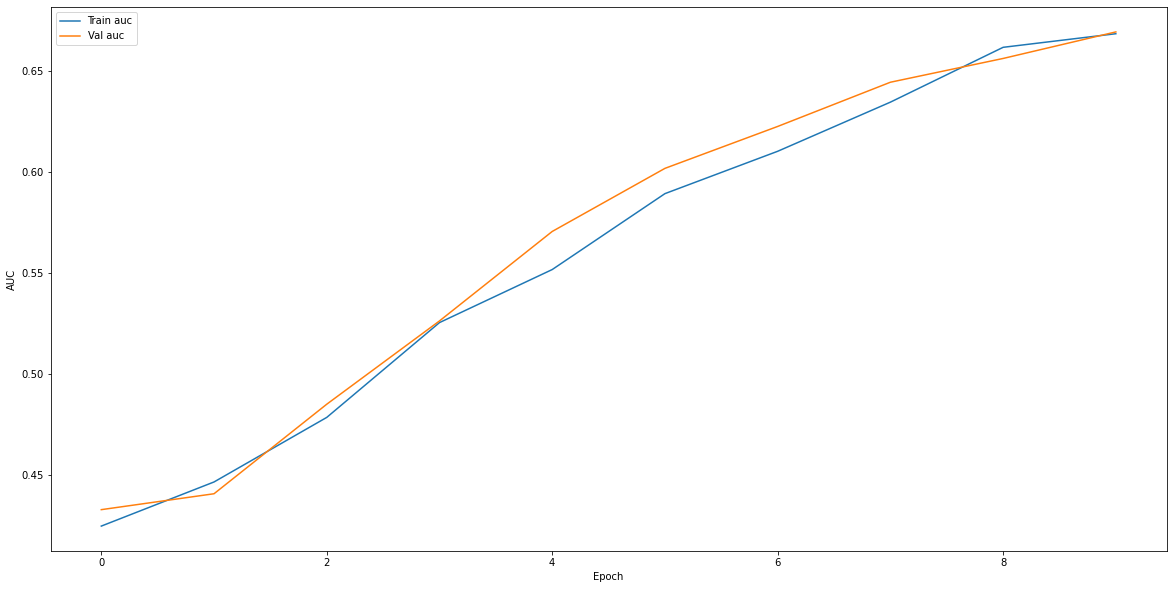

In [39]:
model = keras.Sequential([
        layers.Dense(6, activation='relu', input_shape=(train_data_sc.shape[1],)),  #[len(train['target'])]
        keras.layers.Dropout(0.2),
        layers.Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        layers.Dense(3, activation='relu'),   
        layers.Dense(1, activation='sigmoid')
      ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')


EPOCHS = 10

history = model.fit(train_data_sc, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=True)

plt.rcParams['figure.figsize'] = [20, 10]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.plot(hist['epoch'], hist['auc'], label='Train auc')
plt.plot(hist['epoch'], hist['val_auc'], label = 'Val auc')
plt.legend()

In [40]:
metrics['Keras'] = roc_auc_score(y_test, model.predict_proba(test_data_sc))
print(metrics['Keras'])


0.6803555355535553


In [41]:
metrics
#лучшие результаты у модели логистической регрессии

{'LR': 0.7874662466246625,
 'FR': 0.7856178474990355,
 'CatB': 0.7688938536710813,
 'Keras': 0.6803555355535553}